# Sentiment Analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import unicodedata

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import Dataset
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments
)

from proteccion.utils.paths import data_raw_dir, models_dir

# Set random seed for reproducibility
np.random.seed(42)

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

stop_words = set(stopwords.words('spanish'))

c:\Users\aleja\Projects\technical-tests\proteccion\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aleja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\aleja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aleja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Carga de datos

In [3]:
df = pd.read_csv(data_raw_dir("sentiment_analysis_dataset.csv"))

display(df.head())

print(f"Dataset shape: {df.shape}")
print(f"\nSample text: {df['text'].iloc[0]}")
print(f"\nMissing values:\n{df.isnull().sum()}")

print(f"\nSentiment distribution:\n{df['sentiment'].value_counts()}")
print(f"\nEmotion distribution:\n{df['emotion'].value_counts()}")

,user,text,date,emotion,sentiment
0,@erreborda,termine bien abrumado después de hoy,"Jan 6, 2024 · 2:53 AM UTC",overwhelmed,scared
1,@shpiderduck,me siento abrumado,"Jan 6, 2024 · 2:35 AM UTC",overwhelmed,scared
2,@Alex_R_art,Me siento un poco abrumado por la cantidad de ...,"Jan 6, 2024 · 12:20 AM UTC",overwhelmed,scared
3,@anggelinaa97,Salvador la única persona que no la ha abrumad...,"Jan 5, 2024 · 10:38 PM UTC",overwhelmed,scared
4,@diegoreyesvqz,Denme un helado o algo que ando full abrumado.,"Jan 5, 2024 · 8:38 PM UTC",overwhelmed,scared


Dataset shape: (2590, 5)

Sample text: termine bien abrumado después de hoy

Missing values:
user         0
text         0
date         0
emotion      0
sentiment    0
dtype: int64

Sentiment distribution:
sentiment
peaceful    660
mad         530
powerful    420
sad         360
joyful      350
scared      270
Name: count, dtype: int64

Emotion distribution:
emotion
thankful       150
sleepy         150
overwhelmed    140
jealous        140
successful     140
irritated      140
secure         140
confident      140
surprised      140
embarrassed    130
relaxed        130
distant        130
loving         130
playful        130
isolated       120
frustrated     120
optimistic     110
responsive     110
daring         110
stupid          90
Name: count, dtype: int64


## Preparación de los datos

1. Mapeo de la etiqueta de dsentimiento a `POSITIVE`, `NEGATIVE`, `NEUTRAL`.
2. Creacion de una muestra de 1000 tweets para evaluación

In [4]:
# Map original sentiments to POSITIVE, NEGATIVE, NEUTRAL
sentiment_mapping = {
    'joyful': 'POSITIVE',
    'powerful': 'POSITIVE', 
    'peaceful': 'NEUTRAL',
    'mad': 'NEGATIVE',
    'sad': 'NEGATIVE',
    'scared': 'NEGATIVE'
}

# Apply mapping
df['mapped_sentiment'] = df['sentiment'].map(sentiment_mapping)

# Check the mapping
print("Original sentiment distribution:")
print(df['sentiment'].value_counts())
print("\nMapped sentiment distribution:")
print(df['mapped_sentiment'].value_counts())

# Create a random sample of 1000 tweets
sample_df = df.sample(n=1000, random_state=42)
print(f"\nSample dataset shape: {sample_df.shape}")
print("Sample sentiment distribution:")
print(sample_df['mapped_sentiment'].value_counts())

Original sentiment distribution:
sentiment
peaceful    660
mad         530
powerful    420
sad         360
joyful      350
scared      270
Name: count, dtype: int64

Mapped sentiment distribution:
mapped_sentiment
NEGATIVE    1160
POSITIVE     770
NEUTRAL      660
Name: count, dtype: int64

Sample dataset shape: (1000, 6)
Sample sentiment distribution:
mapped_sentiment
NEGATIVE    452
POSITIVE    291
NEUTRAL     257
Name: count, dtype: int64


## Preprocesamiento de texto

En el siguiente paso, creamos una función de preprocesamiento para limpiar y normalizar el texto en español. Esta función incluye la conversión a minúsculas, la eliminación de URLs, menciones de usuarios, hashtags, caracteres especiales y la normalización de acentos.

In [5]:
def preprocess_text(text):
    """
    Preprocessing function for Spanish text
    """
    # Convert to lowercase
    text = str(text).lower()
    text = ''.join(c for c in unicodedata.normalize(
        'NFD', text) if unicodedata.category(c) != 'Mn')

    # Remove URLs, mentions, hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r"@\w+|#\w+", '', text)

    # Keep only letters and spaces
    text = re.sub(r'[^a-zñü\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)

    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    filtered_text = [word for word in tokens if word not in stop_words and len(word) > 2]

    return " ".join(filtered_text)

# Test the preprocessing function
sample_texts = sample_df['text'].head(3).tolist()
print("Original texts:")
for i, text in enumerate(sample_texts):
    print(f"{i+1}: {text}")

print("\nPreprocessed texts:")
for i, text in enumerate(sample_texts):
    print(f"{i+1}: {preprocess_text(text)}")

# Apply preprocessing to the sample dataset
sample_df['processed_text'] = sample_df['text'].apply(preprocess_text)

Original texts:
1: Extraño esa figura en la casa que estaba atento a todo, resolvía y ayudaba a mi mama y a mí.
2: ni modo, tocó independizarse rápido
3: A los de JxC, y "Periodistas" que estan defendiendo y justificamdo este robo y ataque desvergonzado a la gente, hay que dejarles claro, que de esta NO se vuelve nunca mas. #NoLaVen , #LaCastaErasVos

Preprocessed texts:
1: extrano figura casa atento resolvia ayudaba mama
2: modo toco independizarse rapido
3: jxc periodistas estan defendiendo justificamdo robo ataque desvergonzado gente dejarles claro vuelve nunca mas


## Método 1: Machine Learning tradicional

Vamos a implementar modelos de ML tradicionales utilizando TF-IDF (Basado en conteo) y comparar diferentes algoritmos.

In [6]:
# Split the data into training and testing sets
X = sample_df['processed_text']
y = sample_df['mapped_sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y,
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training set sentiment distribution:")
print(y_train.value_counts())

Training set size: 700
Test set size: 300
Training set sentiment distribution:
mapped_sentiment
NEGATIVE    316
POSITIVE    204
NEUTRAL     180
Name: count, dtype: int64


In [7]:
# Create TF-IDF vectorizer for Spanish text
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # Include both unigrams and bigrams
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.95,  # Ignore terms that appear in more than 95% of documents
    stop_words=None  # We have already removed stopwords in preprocessing
)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")
print(f"Number of unique terms: {len(tfidf_vectorizer.vocabulary_)}")

TF-IDF feature matrix shape: (700, 1675)
Number of unique terms: 1675


In [8]:
# Dictionary to store model results
ml_results = {}

# 1. Naive Bayes Classifier
print("Training Naive Bayes...")
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)
nb_predictions = nb_classifier.predict(X_test_tfidf)

ml_results['Naive Bayes'] = {
    'predictions': nb_predictions,
    'accuracy': accuracy_score(y_test, nb_predictions)
}

print(f"Naive Bayes Accuracy: {ml_results['Naive Bayes']['accuracy']:.4f}")

# 2. Support Vector Machine
print("\nTraining SVM...")
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train_tfidf, y_train)
svm_predictions = svm_classifier.predict(X_test_tfidf)

ml_results['SVM'] = {
    'predictions': svm_predictions,
    'accuracy': accuracy_score(y_test, svm_predictions)
}

print(f"SVM Accuracy: {ml_results['SVM']['accuracy']:.4f}")

# Select the best performing model
best_ml_model = max(ml_results.keys(), key=lambda k: ml_results[k]['accuracy'])
print(f"\nBest ML Model: {best_ml_model} with accuracy: {ml_results[best_ml_model]['accuracy']:.4f}")

Training Naive Bayes...
Naive Bayes Accuracy: 0.6033

Training SVM...
SVM Accuracy: 0.6600

Best ML Model: SVM with accuracy: 0.6600



Detailed Evaluation for SVM:
Classification Report:
              precision    recall  f1-score   support

    NEGATIVE       0.65      0.86      0.74       136
     NEUTRAL       0.70      0.49      0.58        77
    POSITIVE       0.65      0.49      0.56        87

    accuracy                           0.66       300
   macro avg       0.67      0.62      0.63       300
weighted avg       0.66      0.66      0.65       300



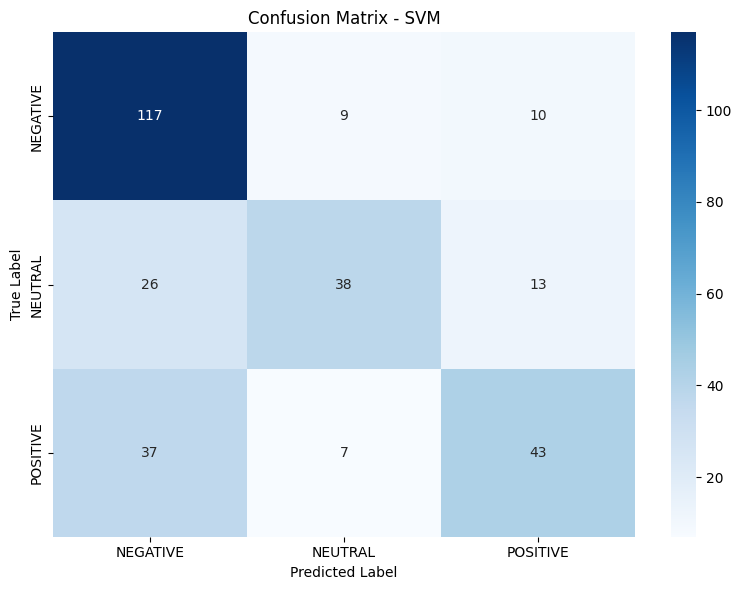

In [9]:
# Detailed evaluation of the best ML model
print(f"\nDetailed Evaluation for {best_ml_model}:")
print("="*50)
best_predictions = ml_results[best_ml_model]['predictions']

print("Classification Report:")
print(classification_report(y_test, best_predictions))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['NEGATIVE', 'NEUTRAL', 'POSITIVE'],
            yticklabels=['NEGATIVE', 'NEUTRAL', 'POSITIVE'])
plt.title(f'Confusion Matrix - {best_ml_model}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## Método 2: Analisis de Sentimiento basado en LLMs

Para este caso, usaremos la biblioteca transformers de Hugging Face para hacer un fine-tuning de un modelo BERT preentrenado en español (`dccuchile/bert-base-spanish-wwm-cased`).

In [10]:
# Redefine a text preprocessing funtion with fewer steps
def preprocess_text_lite(text):
    """
    Preprocessing function for Spanish text
    """
    # Remove URLs, mentions, hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r"@\w+|#\w+", '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)

    return text

sample_texts = df['text'].head(3).tolist()
print("\nPreprocessed texts:")
for i, text in enumerate(sample_texts):
    print(f"{i+1}: {preprocess_text_lite(text)}")

# Apply preprocessing to the entire dataset
df['processed_text'] = df['text'].apply(preprocess_text_lite)


Preprocessed texts:
1: termine bien abrumado después de hoy
2: me siento abrumado
3: Me siento un poco abrumado por la cantidad de cosas que quiero dibujar, ver, jugar y leer. Odio esta sensación xdddd


In [11]:
# Label encoding for the mapped sentiments
le = LabelEncoder()
df['label'] = le.fit_transform(df['mapped_sentiment'])

# Generate Hugging Face Dataset
text_column = "processed_text" # or "text"
dataset = Dataset.from_pandas(df[[text_column, 'label']])

In [12]:
# Load tokenizer
model_name = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(batch):
    return tokenizer(batch[text_column], padding=True , truncation=True, max_length=128)

# Tokenize the dataset
dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.train_test_split(test_size=0.2, seed=42)

Map: 100%|██████████| 2590/2590 [00:00<00:00, 7378.14 examples/s]


In [13]:
# Load pre-trained BERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Training arguments
args = TrainingArguments(
    output_dir=models_dir('bert_results').as_posix(),
    eval_strategy="epoch", # Evaluate the model at the end of each epoch
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2, # Encrease to 5-10 according to computational resources
    logging_steps=10
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset['train'], # type: ignore
    eval_dataset=dataset['test'], # type: ignore
    processing_class=tokenizer,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\aleja\Projects\technical-tests\proteccion\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,0.621700,0.589382
2,0.418100,0.460023


c:\Users\aleja\Projects\technical-tests\proteccion\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=260, training_loss=0.6281958369108347, metrics={'train_runtime': 2849.5763, 'train_samples_per_second': 1.454, 'train_steps_per_second': 0.091, 'total_flos': 272585500766208.0, 'train_loss': 0.6281958369108347, 'epoch': 2.0})

In [14]:
preds = trainer.predict(dataset['test']) # type: ignore
y_pred = np.argmax(preds.predictions, axis=1)
y_true = dataset['test']['label'] # type: ignore

print(classification_report(y_true, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

    NEGATIVE       0.92      0.89      0.90       220
     NEUTRAL       0.77      0.80      0.79       133
    POSITIVE       0.79      0.79      0.79       165

    accuracy                           0.84       518
   macro avg       0.82      0.83      0.83       518
weighted avg       0.84      0.84      0.84       518



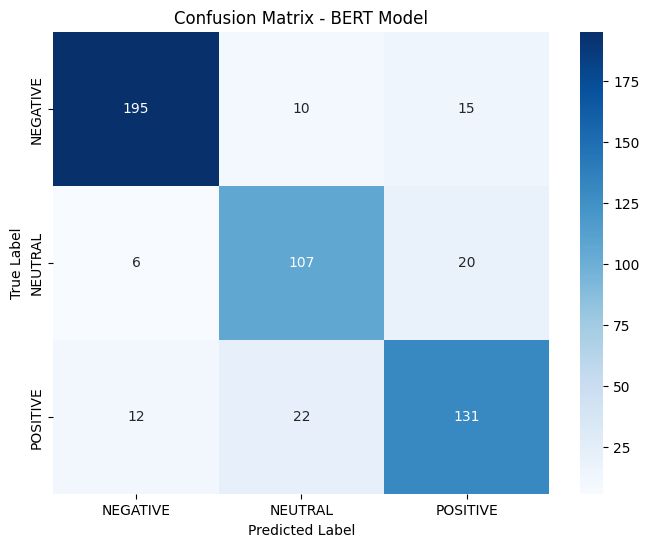

In [ ]:
# Generate confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, # type: ignore
            yticklabels=le.classes_) # type: ignore
plt.title('Confusion Matrix - BERT Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Conlusiones y próximos pasos

* Dadas las caracteristicas de los modelos de lenguaje, es recomendable evaluar el modelo en un conjunto de datos de prueba más grande para obtener una mejor comprensión de su rendimiento.
* Es recomendable reducir la limpieza del texto para preservar el contexto y significado, ya que algunos pasos de limpieza pueden eliminar información relevante para el análisis de sentimiento. Por ejemplo, eliminar emojis, puntuación o convertir todo a minúsculas puede afectar la interpretación del sentimiento en ciertos casos.
* Es posible explorar el uso de modelos más avanzados como Gemini, abordando el problemas mediante prompt engineering. Por ejemplo, se puede utilizar un prompt que guíe al modelo a clasificar el sentimiento de manera más precisa:

    > "Eres un experto en análisis de sentimientos. Clasifica el siguiente texto en una de las siguientes categorías: POSITIVO, NEGATIVO, NEUTRAL. Texto: '{texto}'"

sin embargo este enfoque puede implicar costos adicionales.